#Task: 

Data:  MNIST-type data 26000 images picturing the handwritten digits(0-9).

20000(training_images_clean), 

2000 clean (validation_images_clean) 
and their corresponding noisy (validation_images_noisy) version

Train a
denoising autoencoder (DAE) model to remove noise from images.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

with np.load('denoising-challenge-01-data.npz') as fh:
    training_images_clean = fh['training_images_clean']
    validation_images_noisy = fh['validation_images_noisy']
    validation_images_clean = fh['validation_images_clean']
    test_images_noisy = fh['test_images_noisy']

# TRAINING DATA: CLEAN
# 1. INDEX: IMAGE SERIAL NUMBER (20000)
# 2. INDEX: COLOR CHANNEL (1)
# 3/4. INDEX: PIXEL VALUE (28 x 28)
print(training_images_clean.shape, training_images_clean.dtype)

# VALIDATION DATA: CLEAN + NOISY
print(validation_images_clean.shape, validation_images_clean.dtype)
print(validation_images_noisy.shape, validation_images_noisy.dtype)

# TEST DATA: NOISY
print(test_images_noisy.shape, test_images_noisy.dtype)

# TRAIN MODEL ON training_images_clean

# CHECK YOUR MODEL USING (validation_images_clean, validation_images_noisy)

# DENOISE IMAGES (test_images_clean) USING test_images_noisy

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
#assert test_images_clean.ndim == 4
#assert test_images_clean.shape[0] == 2000
#assert test_images_clean.shape[1] == 1
#assert test_images_clean.shape[2] == 28
#assert test_images_clean.shape[3] == 28

# AND SAVE EXACTLY AS SHOWN BELOW
#np.save('test_images_clean.npy', test_images_clean)

(20000, 1, 28, 28) float32
(2000, 1, 28, 28) float32
(2000, 1, 28, 28) float32
(2000, 1, 28, 28) float32


#Noising the training Data

In [ ]:
noise_factor =  0.4
gaussian_noise = np.random.normal(loc=0.0, scale=1.0, size=(20000,1, 28, 28))
training_images_noisy_Y = training_images_clean + noise_factor * gaussian_noise

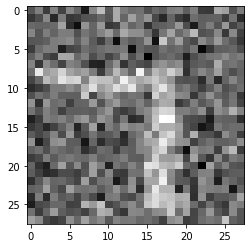

In [ ]:
plt.imshow(training_images_noisy_Y[2][0], cmap='gray')

#Data Setup

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [ ]:
train_noisy_xt, train_clean_yt, val_noisy_xt, val_clean_yt, test_noisy_t = map(
    torch.tensor, (training_images_clean, training_images_noisy_Y, validation_images_clean, validation_images_clean, test_images_noisy)
)

bs = 200  # batch size
train_ds = TensorDataset(train_noisy_xt, train_clean_yt)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

#valid_ds = TensorDataset(val_noisy_xt, val_clean_yt)
#valid_dl = DataLoader(valid_ds, batch_size=200)


In [ ]:
torch.norm(train_noisy_xt-train_clean_yt, p='fro')
#or
torch.sqrt(torch.sum((train_noisy_xt-train_clean_yt) ** 2))

tensor(1583.8262, dtype=torch.float64)

#Define Autoencoder

transpose conv: 
https://www.youtube.com/watch?v=gmr18xg4wTg

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1) #2
        self.conv_2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)#24
        self.convt_1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1, dilation = 1)
        self.convt_2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1, dilation = 1 )
        self.fc = nn.Linear(in_features=3136, out_features=3136)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn_linear = nn.BatchNorm1d(3136)
        self.bn_t1 = nn.BatchNorm2d(num_features=32)
        self.bn_t2 = nn.BatchNorm2d(num_features=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self,x):
        out = self.relu(self.bn1(self.conv_1(x)))
        out = self.relu(self.bn2(self.conv_2(out)))
        return out
    
    def decode(self,x):
        out = self.convt_1(x)
        out = self.relu(self.bn_t1(out))
        out = self.relu(self.bn_t2(self.convt_2(out)))
        return out
    
    def forward(self, x):
        out = self.encode(x)
        out = out.view(out.shape[0],-1)
        out = self.relu(self.bn_linear(self.fc(out)))
        out = out.reshape(out.shape[0],64,7,7)
        out = self.decode(out)
        out = self.relu(out)
        return out 

net = Net()
print(net)

Net(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (convt_1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convt_2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (fc): Linear(in_features=3136, out_features=3136, bias=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_linear): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_t1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_t2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [ ]:
learning_rate = 0.001
#Loss function is Frobenious norm between images
def criterion(X, y):
  return torch.norm(X-y, p='fro')
  #or return torch.sqrt(torch.sum((X-y) ** 2))
optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate)


#Training and validation

In [ ]:
from torch import nn

training_size = len(train_dl.dataset)
validation_size = val_noisy_xt.shape[0]
loss_epoch_trn_list, loss_epoch_val_list = [], [] # loss storage lists

for epoch in range(10):
  current_epoch = epoch + 1
  running_trn_loss, running_batch_trn_loss = 0.0 , 0.0
  print(f"\nEpoch {epoch+1}\n-------------------------------")
  
  #__________________#
  # TRAINING
  #__________________#

  net.train()

  for batch_num, (noisy_img, clean_img) in enumerate(train_dl):
    #input, label = input.to(device), label.to(device)

    # prediction
    pred = net(noisy_img) 
    loss = criterion(pred, clean_img) #evalute loss
    
    # backpropogation 
    loss.backward() 
    optimizer.step()
    optimizer.zero_grad() # zeroes the parameter gradients
    
    # statistics
    running_trn_loss += loss.item()
    running_batch_trn_loss += loss.item() 
         
    if batch_num % 50 == 49:
      current_index = (batch_num+1) * bs
      print(f"loss: {running_batch_trn_loss/(50 * bs) :>7f}  [{current_index:>5d}/{training_size:>5d}]")
      running_batch_trn_loss = 0
  
  # cummulative training loss after each epoch
  epoch_mean_trn_loss = running_trn_loss / training_size
  loss_epoch_trn_list.append(epoch_mean_trn_loss)
  print(f"Training avg loss: {loss_epoch_trn_list[-1]:>7f}")
  
  #_____________#
  # VALIDATION
  #_____________#

  net.eval()
  
  with torch.no_grad():
    val_pred = net(val_noisy_xt)
    val_loss = criterion(val_pred, val_clean_yt)
  epoch_mean_val_loss = val_loss / validation_size
  loss_epoch_val_list.append(epoch_mean_val_loss) # append to list
  print(f"validation avg loss: {loss_epoch_val_list[-1]:>8f}")

  #saving model for minimum validation loss
  if loss_epoch_val_list[-1] <= min(loss_epoch_val_list):
    print("model saved\n")
    torch.save(net, './best_DAE.pth')




Epoch 1
-------------------------------
loss: 0.964722  [10000/20000]
loss: 0.836121  [20000/20000]
Training avg loss: 0.900421
validation avg loss: 0.074196
model saved


Epoch 2
-------------------------------
loss: 0.819166  [10000/20000]
loss: 0.813275  [20000/20000]
Training avg loss: 0.816221
validation avg loss: 0.057532
model saved


Epoch 3
-------------------------------
loss: 0.807230  [10000/20000]
loss: 0.806371  [20000/20000]
Training avg loss: 0.806801
validation avg loss: 0.051376
model saved


Epoch 4
-------------------------------
loss: 0.801367  [10000/20000]
loss: 0.801961  [20000/20000]
Training avg loss: 0.801664
validation avg loss: 0.048511
model saved


Epoch 5
-------------------------------
loss: 0.797468  [10000/20000]
loss: 0.798258  [20000/20000]
Training avg loss: 0.797863
validation avg loss: 0.047488
model saved


Epoch 6
-------------------------------
loss: 0.793188  [10000/20000]
loss: 0.795053  [20000/20000]
Training avg loss: 0.794121
validation 

In [ ]:
#load model
PATH = './best_DAE.pth'
our_saved_model = torch.load(PATH)

In [ ]:
our_saved_model.eval()
with torch.no_grad():
  best_pred = our_saved_model(val_noisy_xt)

# Visulisation of our predicted validation images vs true validation images

## checking our min and max values in images.
clean images are [0, 1]
no normalise:  best_1
so we try to normalise with max value: best _2

In [ ]:
print(np.min(training_images_clean), np.max(training_images_clean))
print(np.min(validation_images_clean), np.max(validation_images_clean))
print(np.min(validation_images_noisy), np.max(validation_images_noisy))
print(np.min(test_images_noisy), np.max(test_images_noisy))

0.0 1.0
0.0 1.0
-0.96896905 1.8351545
-0.9916118 1.9497124


In [ ]:
print(torch.min(best_pred), torch.max(best_pred))
print(torch.min(best_pred[0][0]), torch.max(best_pred[0][0]))

tensor(0.) tensor(1.6608)
tensor(0.) tensor(1.5298)


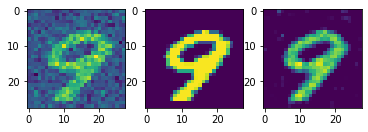

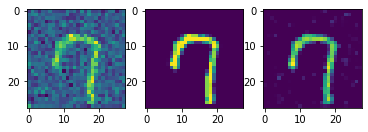

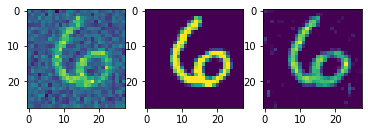

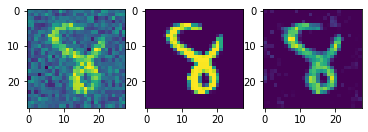

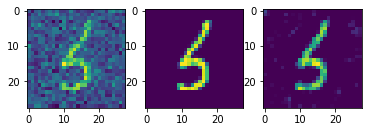

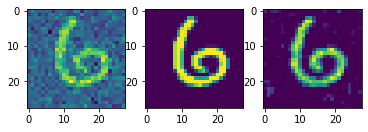

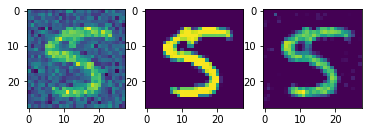

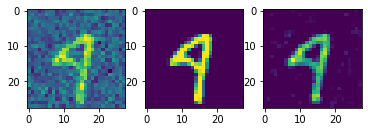

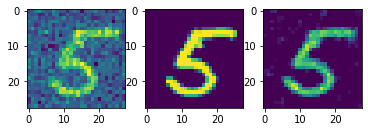

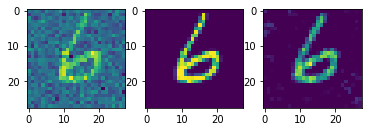

In [ ]:
np_validation_prediction = best_pred.numpy()

rnd_num = np.random.randint(validation_images_clean.shape[0],size = 5)
ROW = 1
COL = 3
for i in rnd_num:
    plt.subplot(ROW,COL,1)
    plt.imshow(validation_images_noisy[i,0])
    plt.subplot(ROW,COL,2)
    plt.imshow(validation_images_clean[i,0])
    plt.subplot(ROW,COL,3)
    plt.imshow(np_validation_prediction[i,0])
    plt.show()

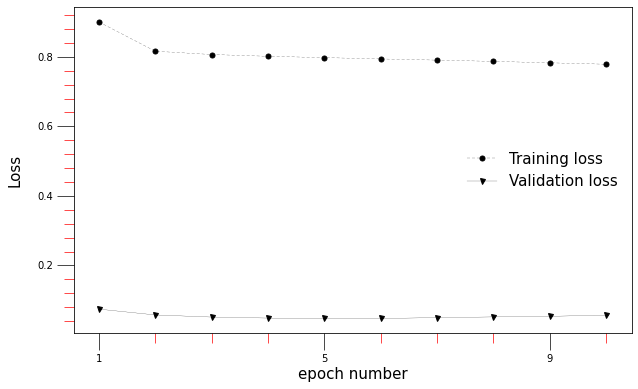

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
fig,ax = plt.subplots(figsize=(10, 6))
x_points = np.arange(1, epoch+2, 1 )
x_points_ = np.arange(1, epoch+3, 4 )
ax.set_xticks(x_points_)
ax.set_xlabel('epoch number',fontsize=15, labelpad =3)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', width=0.7,length=17,direction="out" , labelleft=True )
ax.tick_params(which='minor', width=0.7, length=10, color='r', direction="out")
ax.set_ylabel('Loss',fontsize=15, labelpad=15)
ax.plot(x_points, loss_epoch_trn_list , color = 'black', marker='o', markersize=5 , linestyle='dashed', dashes=(15, 10),linewidth=0.2) 
ax.plot(x_points, loss_epoch_val_list , color = 'black', marker='v', markersize=5 , linestyle='solid', linewidth=0.2) 
ax.legend(['Training loss','Validation loss' ], loc='best', fontsize=15, frameon=False)
plt.show()

# Test_set for submission


In [ ]:
our_saved_model.eval()
with torch.no_grad():
  test_images_clean_t = our_saved_model(test_noisy_t)
test_images_clean = test_images_clean_t.numpy()

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert test_images_clean.ndim == 4
assert test_images_clean.shape[0] == 2000
assert test_images_clean.shape[1] == 1
assert test_images_clean.shape[2] == 28
assert test_images_clean.shape[3] == 28

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('test_images_clean.npy', test_images_clean)